In [ ]:
# Setup: Install Kaggle API for direct dataset download
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

# Unzip the dataset and remove the zip file
!unzip chest-xray-pneumonia.zip && rm chest-xray-pneumonia.zip

In [1]:
%pip install --upgrade pip
%pip install -q evaluate transformers datasets mlflow matplotlib tensorflow scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import tensorflow as tf
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
from sklearn.model_selection import train_test_split

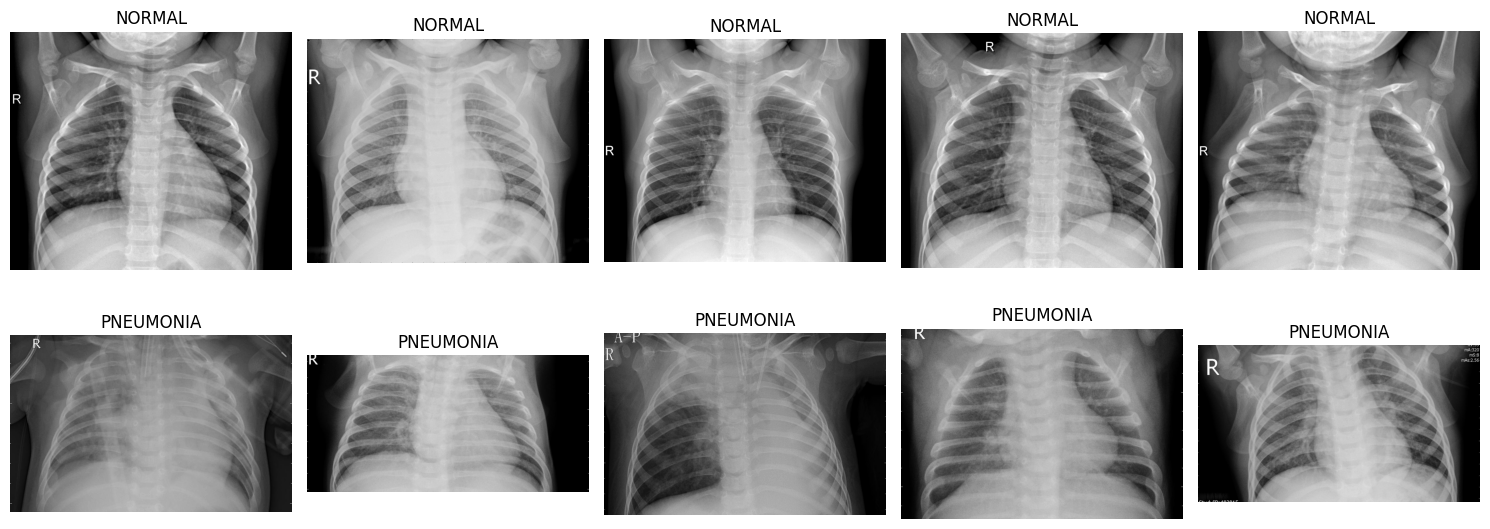

In [6]:
# Directory paths
train_dir = Path("chest_xray/train")
val_dir = Path("chest_xray/val")
test_dir = Path("chest_xray/test")

# Displaying a few images
def display_images(folder, num=5):
    pneumonia_imgs = list(folder.glob('PNEUMONIA/*.jpeg'))[:num]
    normal_imgs = list(folder.glob('NORMAL/*.jpeg'))[:num]

    _, axes = plt.subplots(nrows=2, ncols=num, figsize=(15, 6))

    for i, img_path in enumerate(normal_imgs):
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title("NORMAL")
        axes[0, i].axis('off')

    for i, img_path in enumerate(pneumonia_imgs):
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title("PNEUMONIA")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_images(train_dir)

# Data Preprocessing
Goal: To define transformations for images, to make them applicable to the ViT model

In [7]:
from torchvision import transforms

# Defining transformations for training, validation and testing sets separately
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

label_mapping = {"Normal": 0, "PNEUMONIA": 1}

# Creating Data Loaders
These help in easy iteration through the data, in batches

In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Creating the datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(test_dir, transform=val_test_transforms)

# Creating the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initializing the Visition Transformer Model (ViT)
The ViT Model in question is pre-trained on a larger dataset. We will be fine tuning it to out liking for our chest X-Ray dataset

In [9]:
from transformers import ViTForImageClassification, ViTConfig, ViTImageProcessor

# Configuration for ViT
config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
config.num_labels = 2 # As defined by us above, for Normal and Pneumonia

# Loading the pretrained model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", config=config)

Using the `SDPA` attention implementation on multi-gpu setup with ROCM may lead to performance issues due to the FA backend. Disabling it to use alternative backends.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Initializing the Loss and Optimizer
Cross entropy loss with the Adam Optimizer is suitable for our use

In [10]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training and Tuning our Model
Training the ViT model on our Chest X-Ray Dataset, along with model validation after each epoch

In [11]:
import torch
import torch.nn as nn

# Check if CUDA is available
print("CUDA available: ",torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
  train_losses = [] # Training losses for each epoch
  val_accuracies = [] # Validation accuracy for each epoch

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()

      outputs = model(images).logits # Logits from model outputs
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * images.size(0)

    # Model validation section
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader.dataset)
    val_accuracy = 100 * correct / total

    # Pushing the values for losses and accuracies
    train_losses.append(avg_train_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

  return model, train_losses, val_accuracies

CUDA available:  True


In [12]:
trained_model, train_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

/home/pratham/Downloads/pytorch_rocm/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Epoch 1/10, Loss: 0.2323, Validation Accuracy: 81.25%
Epoch 2/10, Loss: 0.0811, Validation Accuracy: 75.00%
Epoch 3/10, Loss: 0.0555, Validation Accuracy: 81.25%
Epoch 4/10, Loss: 0.0485, Validation Accuracy: 87.50%
Epoch 5/10, Loss: 0.0446, Validation Accuracy: 93.75%
Epoch 6/10, Loss: 0.0367, Validation Accuracy: 93.75%
Epoch 7/10, Loss: 0.0278, Validation Accuracy: 81.25%
Epoch 8/10, Loss: 0.0243, Validation Accuracy: 93.75%
Epoch 9/10, Loss: 0.0254, Validation Accuracy: 75.00%
Epoch 10/10, Loss: 0.0216, Validation Accuracy: 87.50%


# Evaluating Trained Model
Goal: To evaluate previously trained ViT model on test dataset

In [14]:
def evaluate_model(model, test_loader):
  model.eval()
  correct=0
  total=0

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images).logits
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}")

evaluate_model(trained_model, test_loader)

Test Accuracy: 82.69


# Saving and Loading the Model
Goal: To save model weights to avoid retraining when required later

In [15]:
# Saving
torch.save(trained_model.state_dict(), "vit_chest_xray_model.pth")

# We can load in future using the following
# model.load_state_dict(torch.load("vit_chest_xray_model.pth"))

# Training and Validation - Visualization of Metrics
Goal: To understand the models training progress

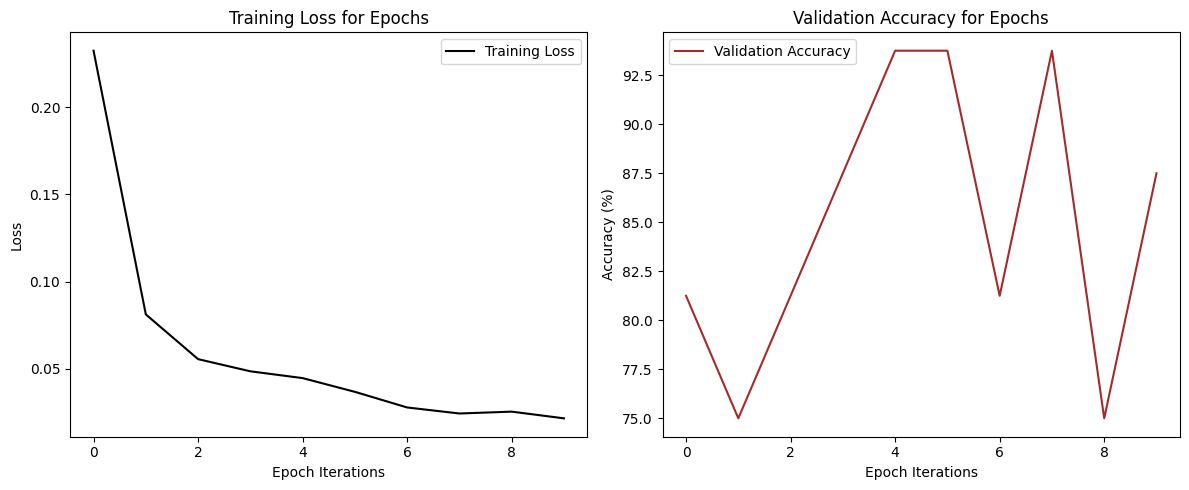

In [16]:
plt.figure(figsize=(12,5))

# Training Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='black')
plt.title('Training Loss for Epochs')
plt.xlabel('Epoch Iterations')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='brown')
plt.title('Validation Accuracy for Epochs')
plt.xlabel("Epoch Iterations")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

# Construction of a Confusion Matrix
Goal: To understand the models performance in better detail, for its predictions

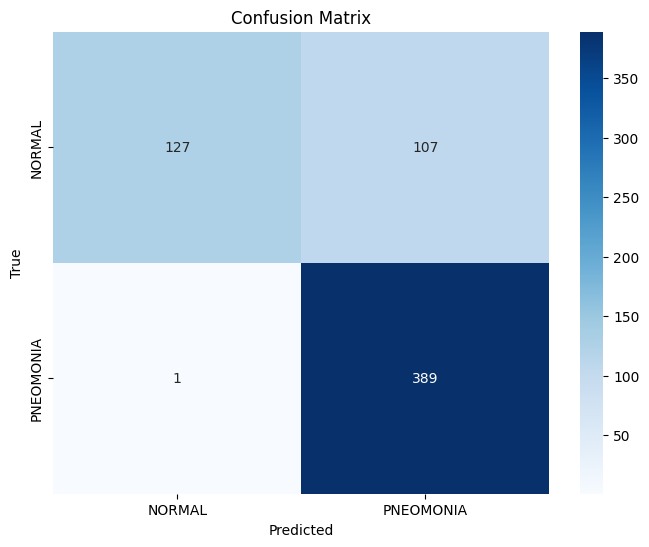

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

# Defining True and Predicted labels
y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images).logits
    _, predicted = outputs.max(1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

labels_list = ["NORMAL", "PNEOMONIA"]
plot_confusion_matrix(y_true, y_pred, labels_list)

In the above image, the confusion matrix shows that the model correctly classified 127 patients as having pneumonia (TP) and 389 patients as not having pneumonia (TN). The model incorrectly classified 1 patient as having pneumonia (FP) and 107 patients as not having pneumonia (FN).